### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12433
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|     4|[80 4D 80 C9 00 0...|1907.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    29|[00 7E A0 53 00 C...|1911.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    18|[40 CC 40 4C 80 C...|1912.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    36|[40 56 A0 56 58 5...|1915.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    40|[20 50 30 54 30 5...|1916.0|SSSBBSSB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [5]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00421272')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=(T*0.0394/10)  # Scaling to convert mm to inches.
#T=T/10           # Scaling to convert to degree celcius
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00421272'
42 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1731.9| 37.6833|-113.0833|       PRCP|USC00421272|    31|[C0 50 80 4A 00 0...|1906.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       PRCP|USC00421272|     2|[20 51 00 00 00 0...|1907.0|SSSBBSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(42, 365)

### Script for plotting yearly plots

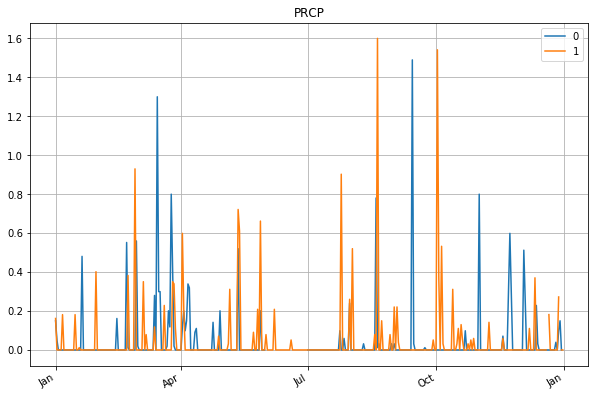

In [6]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [8]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,len(pair),figsize=(16,6))
    if(len(pair)>1):
        axes=X.reshape(len(pair))
        for m in pair:
            axis = axes[j]
            j+=1
            func(m,fig,axis)
    else:
        func(pair[0], fig, X)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/home/tejas/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


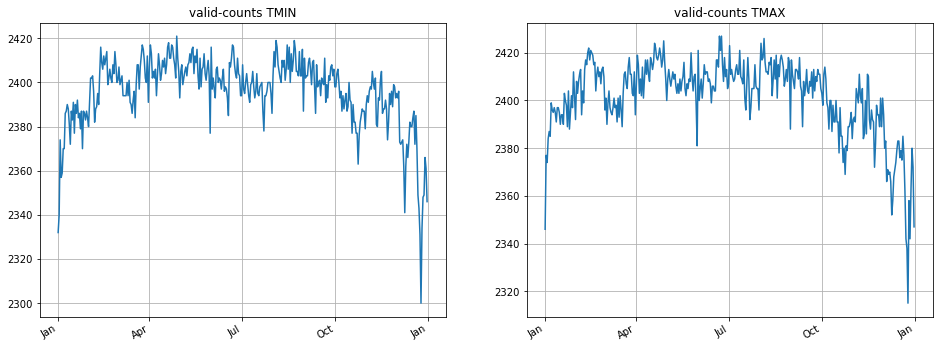

In [9]:
plot_pair(['TMIN','TMAX'],plot_valid)

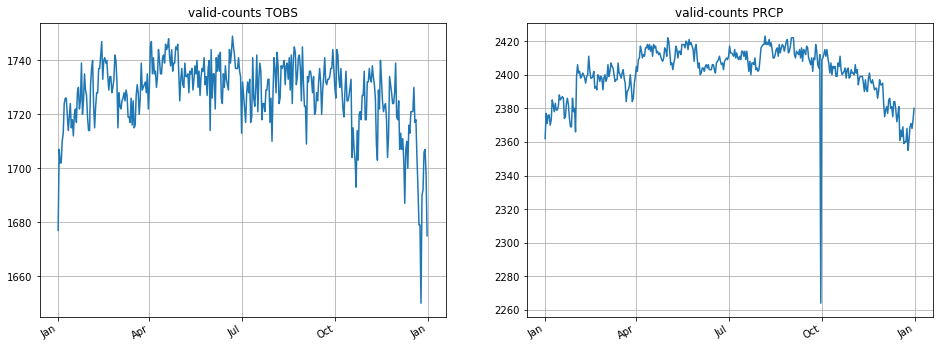

In [10]:
plot_pair(['TOBS','PRCP'],plot_valid)

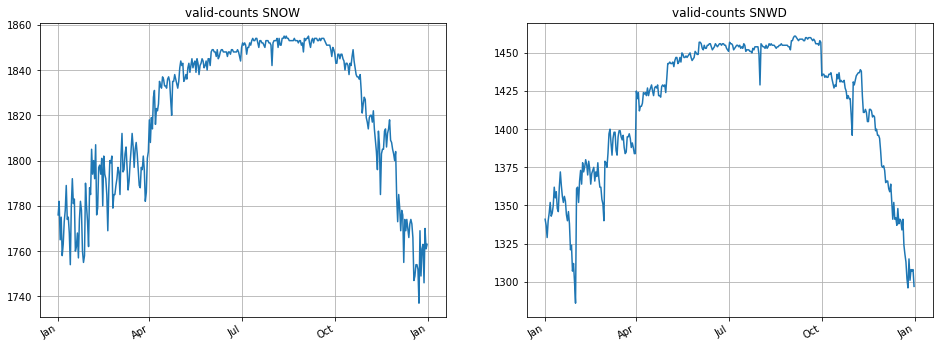

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [22]:
def plot_mean_std(m,fig,axis):
    if(m[0] == 'T'):
        mean=(STAT[m]['Mean']/10)*9/5+32   #To convert to farenheit
        std=(np.sqrt(STAT[m]['Var'])/10)*9/5  #To converto to farenheit
    elif(m[0] == 'P'):
        mean=(STAT[m]['Mean'])*0.0394/10   #To convert to inches
        mean_val = np.mean(mean)
        print "Mean precipitation per day in the year = %f"%mean_val
        std=(np.sqrt(STAT[m]['Var']))*0.0394/10  #To converto to inches
    else:
        mean=(STAT[m]['Mean'])*0.0394   #TO convert to inches
        std=(np.sqrt(STAT[m]['Var']))*0.0394   #To convert to inches
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

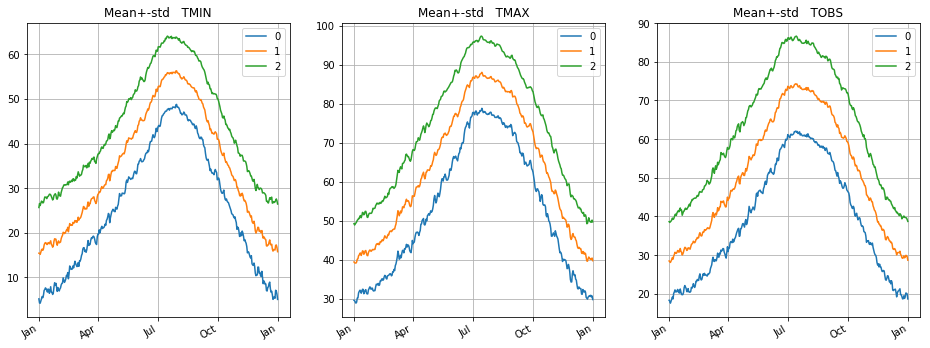

In [23]:
plot_pair(['TMIN','TMAX', 'TOBS'],plot_mean_std)

Mean precipitation per day in the year = 0.036458


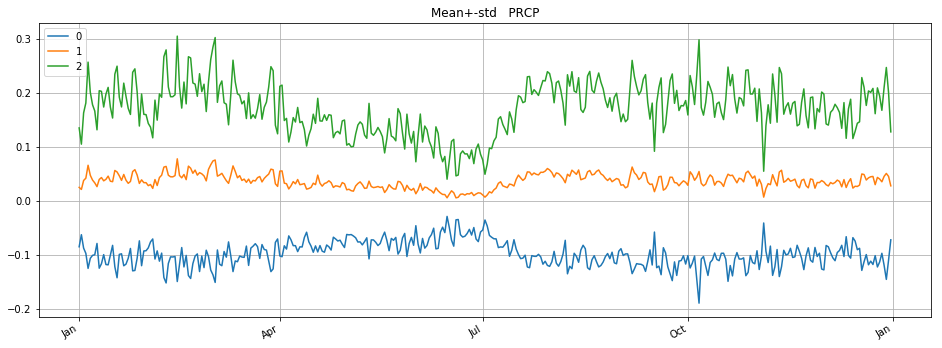

In [24]:
plot_pair(['PRCP'],plot_mean_std)

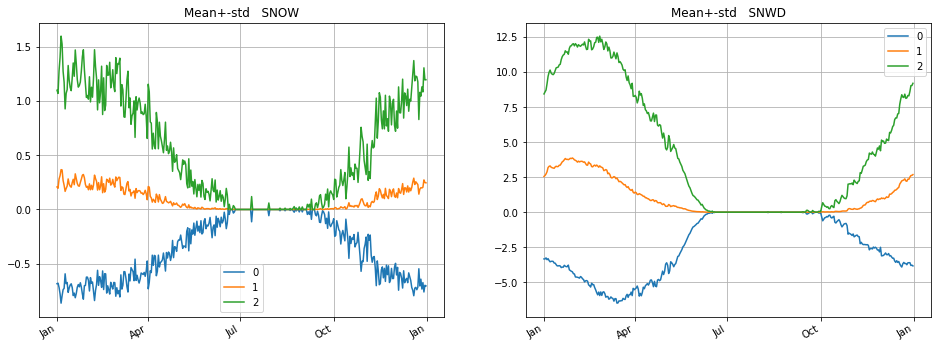

In [59]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [15]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

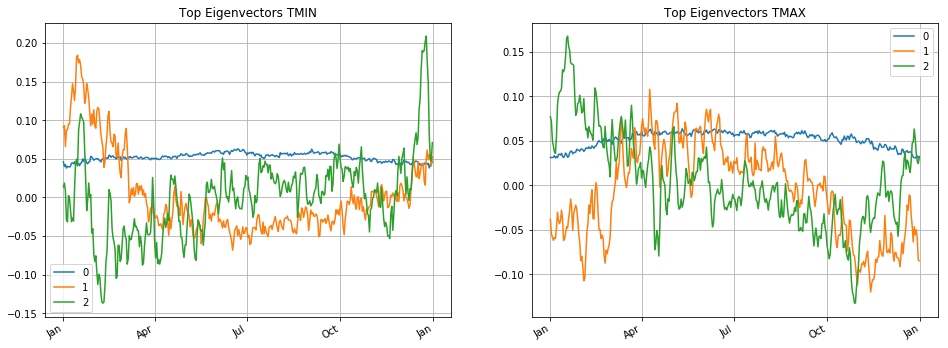

In [16]:
plot_pair(['TMIN','TMAX'],plot_eigen)

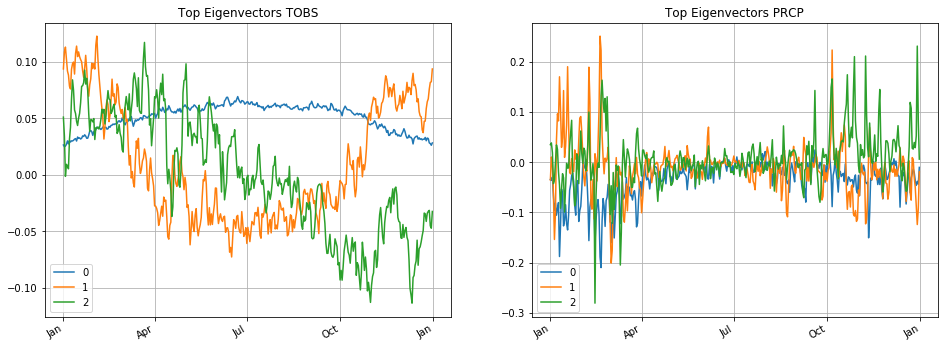

In [17]:
plot_pair(['TOBS','PRCP'],plot_eigen)

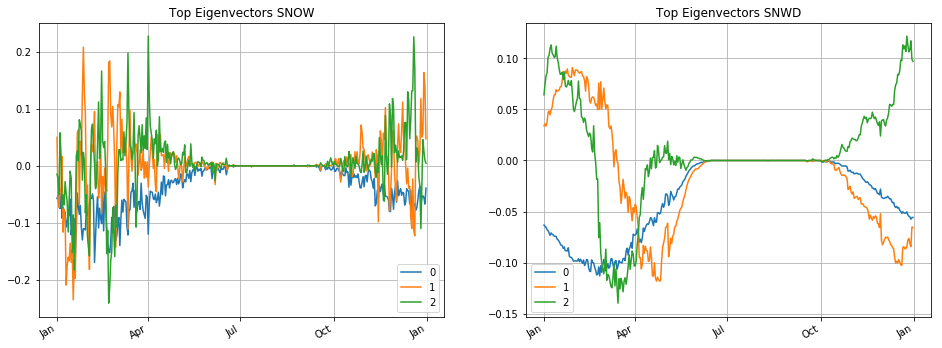

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [27]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    print cumsum(EV[:k])/sum(EV[:])
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

[ 0.38852597  0.41811221  0.4409985   0.46180147  0.47809982]
[ 0.54892422  0.57305226  0.59208006  0.60613725  0.61956441]
[ 0.39928235  0.43092046  0.45936414  0.48423348  0.50521507]


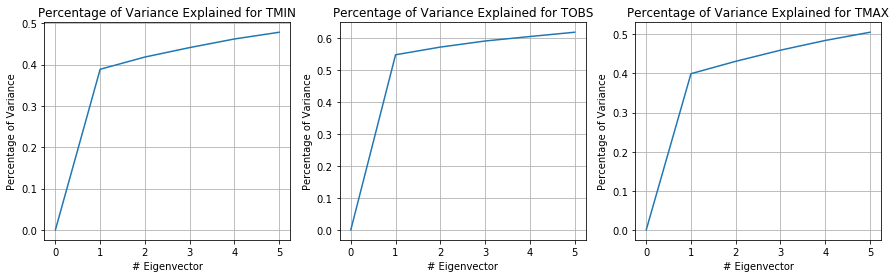

In [28]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

[ 0.04946042  0.07078823  0.09097525  0.11048314  0.12987465]
[ 0.70718628  0.79107706  0.84040703  0.86677237  0.88442024]
[ 0.02972929  0.05196042  0.07008641  0.08694018  0.10294766]


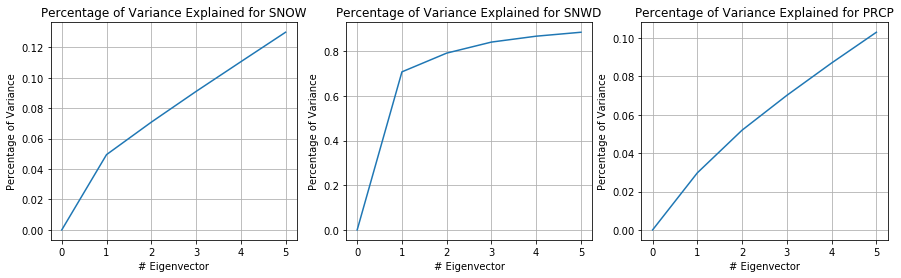

In [29]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [30]:
sc.stop()

In [20]:
a=['tejas', 'saxena']
print (len(a))

2
